In [14]:
using Pkg
using CSV
using DataFrames
using Random
using Clustering
using Statistics
using Plots
#Pkg.add("Distances")
using Distances

In [21]:
#removing extra columns
data = CSV.File("71-80.csv")
df = DataFrame(data)
columns_to_drop = ["univ_rank","first_initial", "last_initial","cit_2022","h_index", "i_10_index"]
columns_to_drop2 = ["univ_rank","first_initial", "last_initial","h_index", "i_10_index"]

updated_df = select(df, Not(columns_to_drop))
updated_df2 = select(df, Not(columns_to_drop2))   

# Shuffle the rows
shuffled_df = updated_df[shuffle(1:end), :]
shuffled_df2 = updated_df2[shuffle(1:end), :]
# Split the data into training and testing sets
split_index = floor(Int, 0.8 * nrow(shuffled_df))
    
# Use all columns for train_data and test_data split
train_data_all = shuffled_df2[1:split_index, :]
test_data_all = shuffled_df2[split_index+1:end, :]

train_data = shuffled_df[1:split_index, :]
test_data = shuffled_df[split_index+1:end, :]

Row,cit_2017,cit_2018,cit_2019,cit_2020,cit_2021
,Int64,Int64,Int64,Int64,Int64
1,98,117,73,134,62
2,336,360,337,321,298
3,49,45,28,42,27
4,28,34,34,16,33
5,156,183,191,166,267
6,6,5,37,41,39
7,806,657,543,441,404
8,39,48,33,36,43
9,930,1114,1236,1163,1184


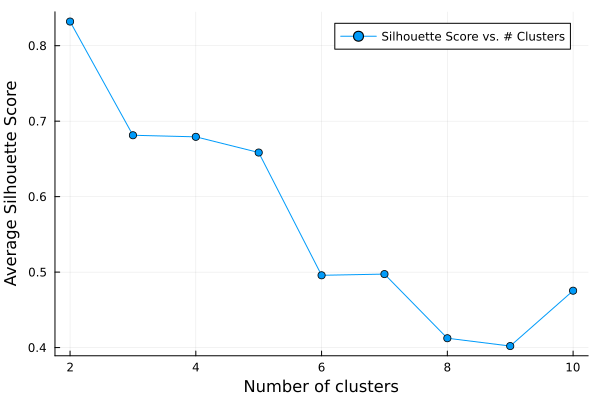

In [22]:
X_train = Matrix(train_data)
# Calculate the average silhouette score for a given clustering
function avg_silhouette(X, result)
    sil_vals = silhouettes(result.assignments, pairwise(Euclidean(), X'))
    return mean(sil_vals)
end

K = 10  # You can adjust this value as needed
sil_scores = []

for k in 2:K  # Silhouette is not defined for k = 1
    result = kmeans(X_train', k)
    push!(sil_scores, avg_silhouette(X_train, result))
end

plot(2:K, sil_scores, xlabel="Number of clusters", ylabel="Average Silhouette Score", m=:circle, label="Silhouette Score vs. # Clusters")

In [23]:
#Choosing k = 4 as it gives the highest silhoutte score as displayed above
k_optimal = 4
kmeans_result = kmeans(X_train', k_optimal)

function assign_nearest(centers, data_points)
    assignments = []
    for point in eachcol(data_points)
        distances = [euclidean(point, center) for center in eachcol(centers)]
        push!(assignments, argmin(distances))
    end
    return assignments
end

# Assigning each test data to the nearest cluster centroid
assignments = assign_nearest(kmeans_result.centers, Matrix(test_data)')

20-element Vector{Any}:
 1
 1
 1
 1
 1
 1
 4
 1
 3
 1
 1
 4
 1
 1
 1
 4
 1
 1
 1
 1

In [24]:
# Predictions
pred_nearest_neighbor = []
pred_nearest_centroid = []
pred_avg_cluster = []

for i in 1:size(test_data, 1)
    cluster = assignments[i] # assuming `assignments` has been previously computed
    members = findall(kmeans_result.assignments .== cluster) # assuming `kmeans_result` has been previously computed
    
    # Find nearest neighbor in the training set using columns 2017-2021
    distances = [euclidean(Array(test_data[i, 1:end]), Array(train_data[j, 1:end])) for j in members]
    nearest_neighbor = members[argmin(distances)]
    
    # Using cit_2022 of the nearest neighbor in the training set for the prediction
    push!(pred_nearest_neighbor, train_data_all[nearest_neighbor, :cit_2022])
    
    # Finding the training point nearest to the cluster centroid
    centroid_distances = [euclidean(kmeans_result.centers[:, cluster], Array(train_data[j, 1:end])) for j in members]
    nearest_to_centroid = members[argmin(centroid_distances)]
    
    # Using cit_2022 of the point nearest to the cluster centroid for the prediction
    push!(pred_nearest_centroid, train_data_all[nearest_to_centroid, :cit_2022])
    
    # Using mean of cit_2022 for average cluster prediction
    push!(pred_avg_cluster, mean(train_data_all[members, :cit_2022]))
end

In [25]:
# Tabulating the results
results = DataFrame(
    Actual_2022 = test_data_all.cit_2022,
    Nearest_Neighbor_Prediction = pred_nearest_neighbor,
    Nearest_Centroid_Prediction = pred_nearest_centroid,
    Average_Cluster_Prediction = pred_avg_cluster
)

Row,Actual_2022,Nearest_Neighbor_Prediction,Nearest_Centroid_Prediction,Average_Cluster_Prediction
,Int64,Any,Any,Any
1,21,1279,685,432.948
2,2933,289,685,432.948
3,129,107,685,432.948
4,98,1012,685,432.948
5,129,2800,685,432.948
6,188,1012,685,432.948
7,27,124,155,292.769
8,638,107,685,432.948
9,279,180,746,247.667


In [20]:
# Computing the average difference magnitude for each prediction method
error_nearest_neighbor = mean(abs.(results.Actual_2022 - results.Nearest_Neighbor_Prediction))
error_nearest_centroid = mean(abs.(results.Actual_2022 - results.Nearest_Centroid_Prediction))
error_avg_cluster = mean(abs.(results.Actual_2022 - results.Average_Cluster_Prediction))

# Print out the results
println("Average Difference Magnitude (Nearest Neighbor Prediction): ", error_nearest_neighbor)
println("Average Difference Magnitude (Nearest Centroid Prediction): ", error_nearest_centroid)
println("Average Difference Magnitude (Average Cluster Prediction): ", error_avg_cluster)


Average Difference Magnitude (Nearest Neighbor Prediction): 543.3
Average Difference Magnitude (Nearest Centroid Prediction): 482.6
Average Difference Magnitude (Average Cluster Prediction): 358.7671212121212
